In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import parameters as param
import mpi4py.MPI as MPI
import uuid
import logging
logger = logging.getLogger(__name__)
%matplotlib notebook

In [2]:
import importlib
importlib.reload(param)

<module 'parameters' from '/Users/kburns/Hg/pg_coupling/compressible/notebooks/parameters.py'>

## Background

In [3]:
domain, p_bvp = atmos.solve_hydrostatic_pressure(param, np.complex128)
p_full, p0, a_full, a0, heq, N2 = atmos.truncate_background(param, p_bvp)

2017-08-17 16:40:34,341 domain 0/1 DEBUG :: Global coeff shape: [128]
2017-08-17 16:40:34,343 distributor 0/1 DEBUG :: Mesh: []
2017-08-17 16:40:34,346 problems 0/1 DEBUG :: Parsing Eqn 0
2017-08-17 16:40:34,347 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:40:34,348 problems 0/1 DEBUG ::   LHS string form: dz(pz) + (N2/g)*pz
2017-08-17 16:40:34,349 problems 0/1 DEBUG ::   RHS string form: pz*pz/p/γ
2017-08-17 16:40:34,351 problems 0/1 DEBUG ::   LHS object form: dz(pz) + ((N2*(g**-1))*pz)
2017-08-17 16:40:34,351 problems 0/1 DEBUG ::   RHS object form: ((pz*pz)*(p**-1))*(γ**-1)
2017-08-17 16:40:34,355 problems 0/1 DEBUG ::   L linear form: dz(δpz) + ((N2*(g**-1))*δpz)
2017-08-17 16:40:34,357 problems 0/1 DEBUG ::   dF linear form: ((((pz*pz)*(-1*(p**-2)))*(γ**-1))*δp) + ((((pz*(p**-1))*(γ**-1))*δpz) + (((pz*(p**-1))*(γ**-1))*δpz))
2017-08-17 16:40:34,358 problems 0/1 DEBUG :: Parsing Eqn 1
2017-08-17 16:40:34,359 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:40:34,360 

## Problem

In [8]:
# Adiabatic viscous fully-compressible hydrodynamics
problem = de.EVP(domain, variables=['a1','p1','u','w','uz','wz'], eigenvalue='σ', ncc_cutoff=param.ivp_cutoff, entry_cutoff=param.matrix_cutoff)
problem.meta[:]['z']['dirichlet'] = True
problem.parameters['a0'] = a0
problem.parameters['p0'] = p0
problem.parameters['a0z'] = a0.differentiate('z')
problem.parameters['p0z'] = p0.differentiate('z')
problem.substitutions['a0x'] = "0" #a0.differentiate('x')
problem.substitutions['p0x'] = "0" #p0.differentiate('x')
problem.parameters['kx'] = kx = param.k_tide

problem.parameters['U'] = 0
problem.parameters['μ'] = param.μ
problem.parameters['γ'] = param.γ
problem.parameters['Lz'] = param.Lz
problem.substitutions['dt(A)'] = "-1j*σ*A"
problem.substitutions['dx(A)'] = "1j*kx*A"
problem.substitutions['ux'] = "dx(u)"
problem.substitutions['wx'] = "dx(w)"
problem.substitutions['div_u'] = "ux + wz"
problem.substitutions['txx'] = "μ*(2*ux - 2/3*div_u)"
problem.substitutions['txz'] = "μ*(wx + uz)"
problem.substitutions['tzz'] = "μ*(2*wz - 2/3*div_u)"
problem.substitutions['φ'] = "0"
problem.substitutions['cs20'] = "γ*p0*a0"
problem.add_equation("dt(u) + U*ux + a0*dx(p1) + a1*p0x - a0*(dx(txx) + dz(txz)) = - (u*ux + w*uz) - a1*dx(p1) + a1*(dx(txx) + dz(txz)) - dx(φ)")
problem.add_equation("dt(w) + U*wx + a0*dz(p1) + a1*p0z - a0*(dx(txz) + dz(tzz)) = - (u*wx + w*wz) - a1*dz(p1) + a1*(dx(txz) + dz(tzz)) - dz(φ)")
problem.add_equation("dt(a1) + U*dx(a1) + u*a0x + w*a0z -   a0*div_u = - (U*a0x + u*dx(a1) + w*dz(a1)) +   a1*div_u")
problem.add_equation("dt(p1) + U*dx(p1) + u*p0x + w*p0z + γ*p0*div_u = - (U*p0x + u*dx(p1) + w*dz(p1)) - γ*p1*div_u")
problem.add_equation("uz - dz(u) = 0")
problem.add_equation("wz - dz(w) = 0")
problem.add_bc("left(txz) = 0")
problem.add_bc("right(txz) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0")

2017-08-17 16:43:07,055 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2017-08-17 16:43:07,057 problems 0/1 DEBUG :: Parsing Eqn 0
2017-08-17 16:43:07,058 problems 0/1 DEBUG ::   Condition: True
2017-08-17 16:43:07,059 problems 0/1 DEBUG ::   LHS string form: dt(u) + U*ux + a0*dx(p1) + a1*p0x - a0*(dx(txx) + dz(txz))
2017-08-17 16:43:07,060 problems 0/1 DEBUG ::   RHS string form: - (u*ux + w*uz) - a1*dx(p1) + a1*(dx(txx) + dz(txz)) - dx(φ)
2017-08-17 16:43:07,064 problems 0/1 DEBUG ::   LHS object form: (((((-0-1j)*σ)*u) + (U*((1j*kx)*u))) + (a0*((1j*kx)*p1))) + (-1*(a0*(((1j*kx)*(μ*((2*((1j*kx)*u)) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz)))))) + dz(μ*(((1j*kx)*w) + uz)))))
2017-08-17 16:43:07,065 problems 0/1 DEBUG ::   RHS object form: ((-1*((u*((1j*kx)*u)) + (w*uz))) + (-1*(a1*((1j*kx)*p1)))) + (a1*(((1j*kx)*(μ*((2*((1j*kx)*u)) + (-1*(0.6666666666666666*(((1j*kx)*u) + wz)))))) + dz(μ*(((1j*kx)*w) + uz))))
2017-08-17 16:43:07,086 problems 0/1 DEBUG ::  

## Solver

In [9]:
# Build solver
solver = problem.build_solver()
pencil = solver.pencils[0]
cacheid = uuid.uuid4()
pencil.build_matrices(problem, ['M', 'L'], cacheid=cacheid)
solver.eigenvalue_pencil = pencil

2017-08-17 16:43:10,964 solvers 0/1 DEBUG :: Beginning EVP instantiation
2017-08-17 16:43:10,966 solvers 0/1 DEBUG :: Finished EVP instantiation
2017-08-17 16:43:11,054 field 0/1 DEBUG :: Expanded NCC 'a0*(1j*kx)' to mode 35 with 36 terms.
2017-08-17 16:43:11,091 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(2*(1j*kx)))))' to mode 14 with 15 terms.
2017-08-17 16:43:11,121 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*(-1*(0.6666666666666666*(1j*kx))))))' to mode 11 with 12 terms.
2017-08-17 16:43:11,148 field 0/1 DEBUG :: Expanded NCC '-1*(a0*((1j*kx)*(μ*-0.6666666666666666)))' to mode 10 with 11 terms.
2017-08-17 16:43:11,177 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 10 with 11 terms.
2017-08-17 16:43:11,205 field 0/1 DEBUG :: Expanded NCC '-1*(a0*μ)' to mode 10 with 11 terms.
2017-08-17 16:43:11,292 field 0/1 DEBUG :: Expanded NCC 'a0' to mode 33 with 34 terms.
2017-08-17 16:43:11,360 field 0/1 DEBUG :: Expanded NCC 'p0z' to mode 26 with 27 terms.
2017-08-17 16

<IPython.core.display.Javascript object>


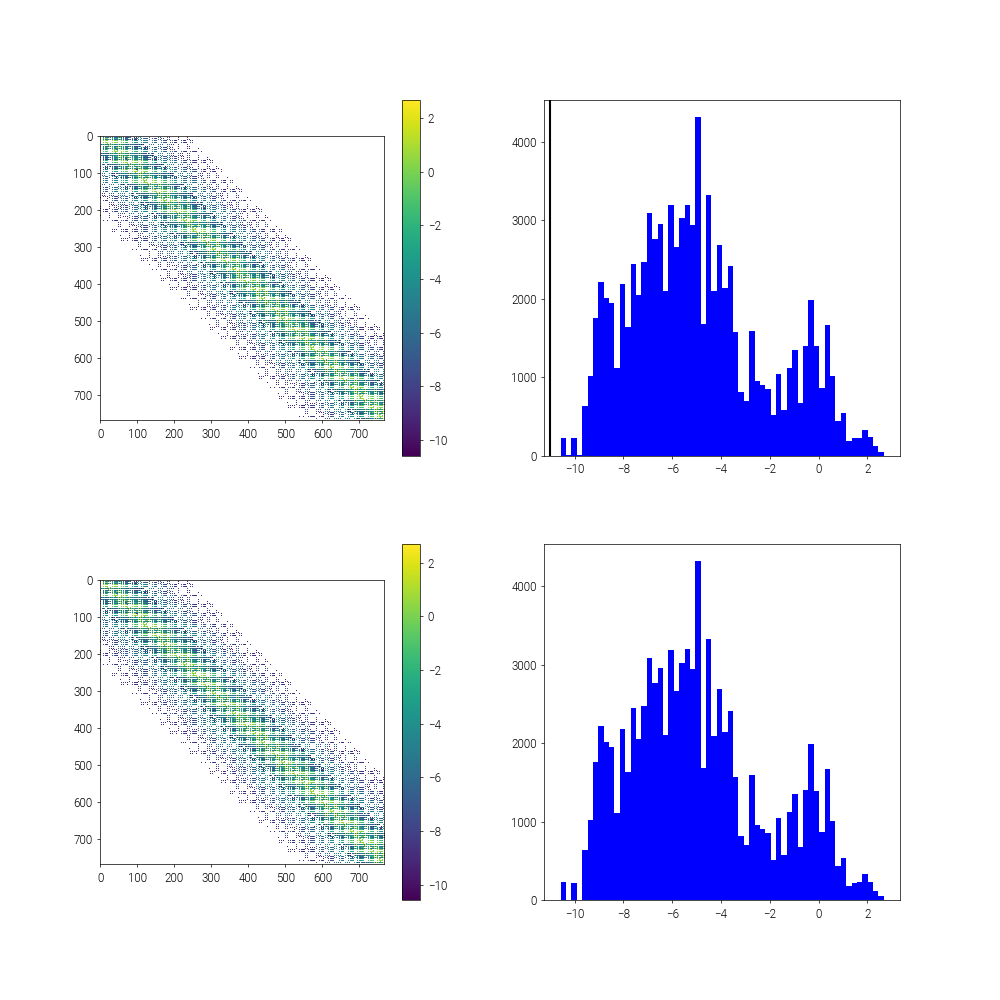

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
L = pencil.L_exp.copy()
M = pencil.M_exp.copy()
# Plot L matrix
im1 = ax1.imshow(np.log10(np.abs(L.A)), cmap='viridis')
im2 = ax2.hist(np.log10(np.abs(L.A[L.A!=0])), bins=60)
ax2.axvline(np.log10(param.matrix_cutoff), c='k')
ax1.set_aspect('equal')
plt.colorbar(im1, ax=ax1)
# Filter low entries
L[np.abs(L) < param.matrix_cutoff] = 0
M[np.abs(M) < param.matrix_cutoff] = 0
L.eliminate_zeros()
M.eliminate_zeros()
# Plot filtered L matrix
im1 = ax3.imshow(np.log10(np.abs(L.A)), cmap='viridis')
im2 = ax4.hist(np.log10(np.abs(L.A[L.A!=0])), bins=60)
plt.colorbar(im1, ax=ax3)

In [11]:
from scipy.sparse import linalg as spla
from petsc4py import PETSc
from slepc4py import SLEPc
from scipy import sparse
from scipy import linalg


def scipy_to_petsc(A_sc):
    """
    Build PETSc sparse matrices from scipy sparse matrices.

    Parameters
    ----------
    A_sc : scipy sparse matrix

    """
    # Explicitly add zeros to diagonal
    A_sc = A_sc.tocoo()
    data = np.concatenate((A_sc.data, np.zeros(A_sc.shape[0])))
    row = np.concatenate((A_sc.row, np.arange(A_sc.shape[0])))
    col = np.concatenate((A_sc.col, np.arange(A_sc.shape[0])))
    A_sc = sparse.coo_matrix((data, (row, col)))
    # Build PETSc matrix using CSR description
    A_sc = A_sc.tocsr()
    A_pe = PETSc.Mat()
    A_pe.createAIJ(size=A_sc.shape, csr=(A_sc.indptr, A_sc.indices, A_sc.data))
    return A_pe


def scipy_dense_eigs(A_sc, B_sc, N=5):
    """
    Compute smallest magnitude eigenvalues using scipy dense solver for the
    generalized eigenvalue problem

        A.x = λ B.x

    Parameters
    ----------
    A_sc, B_sc : scipy sparse matrices
        Sparse matrices for generalized eigenvalue problem
    N : int
        Number of eigenvalues to return

    """
    # Solve using scipy dense algorithm
    evals, evecs = linalg.eig(a=A_sc.A, b=B_sc.A)
    evals = evals[np.isfinite(evals)]
    evals = evals[np.argsort(np.abs(evals))]
    return evals[:N]


def scipy_sparse_eigs(A_sc, B_sc, N=5):
    """
    Compute smallest magnitude eigenvalues using scipy sparse solver for the
    reformulated generalized eigenvalue problem

        A.x = λ B.x  ==>  (A^-1).B.x = (1/λ) x

    Parameters
    ----------
    A_sc, B_sc : scipy sparse matrices
        Sparse matrices for generalized eigenvalue problem
    N : int
        Number of eigenvalues to return

    """
    # Build sparse linear operator representing (A^-1).B
    def matvec(x):
        return spla.spsolve(A_sc, B_sc.dot(x))
    A = spla.LinearOperator(dtype=A_sc.dtype, shape=A_sc.shape, matvec=matvec)
    # Solve using scipy sparse algorithm
    evals, evecs = spla.eigs(A, k=N, which='LM', tol=1e-10)
    evals = 1 / evals
    evals = evals[np.isfinite(evals)]
    evals = evals[np.argsort(np.abs(evals))]
    return evals


def slepc_sparse_eigs(A_sc, B_sc, N=5, target=0, tol=1e-10, verbose=True):
    """
    Compute smallest magnitude eigenvalues using SLEPc iterative sparse solver
    for the generalized eigenvalue problem

        A.x = λ B.x

    Parameters
    ----------
    A_sc, B_sc : scipy sparse matrices
        Sparse matrices for generalized eigenvalue problem
    N : int
        Number of eigenvalues to return
    verbose : boolean, optional
        Print solver statistics

    """
    # Build PETSc matrices
    A_pe = scipy_to_petsc(A_sc)
    B_pe = scipy_to_petsc(B_sc)
    # Build SLEPc eigenvalue problem solver
    EPS = SLEPc.EPS()
    EPS.create()
    EPS.setOperators(A_pe, B_pe)
    EPS.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
    EPS.setTarget(target)
    EPS.setTolerances(tol=tol)
    EPS.setDimensions(nev=N)
    # Specify shift-inversion since B may be singular
    ST = EPS.getST()
    ST.setType('sinvert')
    # Specify direct LU factorization for the solver
    KSP = ST.getKSP()
    KSP.setType('preonly')
    PC = KSP.getPC()
    PC.setType('lu')
    PC.setFactorSolverPackage('mumps')
    # Solve
    EPS.solve()
    if verbose:
        print("  SLEPc iterations:", EPS.getIterationNumber())
        print("  SLEPc solution method:", EPS.getType())
        print("  SLEPc number of requested eigenvalues:", EPS.getDimensions()[0])
        print("  SLEPc number of converged eigenvalues:", EPS.getConverged())
    # Assemble output
    evals = []
    evecs = []
    vr, wr = A_pe.getVecs()
    vi, wi = A_pe.getVecs()
    for i in range(EPS.getConverged()):
        evals.append(EPS.getEigenpair(i, vr, vi))
        evecs.append(vr.getArray() + 1j*vi.getArray())
    evals = np.array(evals)
    evecs = np.array(evecs).T
    #evals = evals[np.isfinite(evals)]
    #evals = evals[np.argsort(np.abs(evals))]
    return evals, evecs

In [12]:
evals, evecs = slepc_sparse_eigs(L, -M, N=10, target=1.0-0.01j)
solver.eigenvalues = evals
solver.eigenvectors = pencil.JD @ evecs

  SLEPc iterations: 76
  SLEPc solution method: krylovschur
  SLEPc number of requested eigenvalues: 10
  SLEPc number of converged eigenvalues: 10


<IPython.core.display.Javascript object>


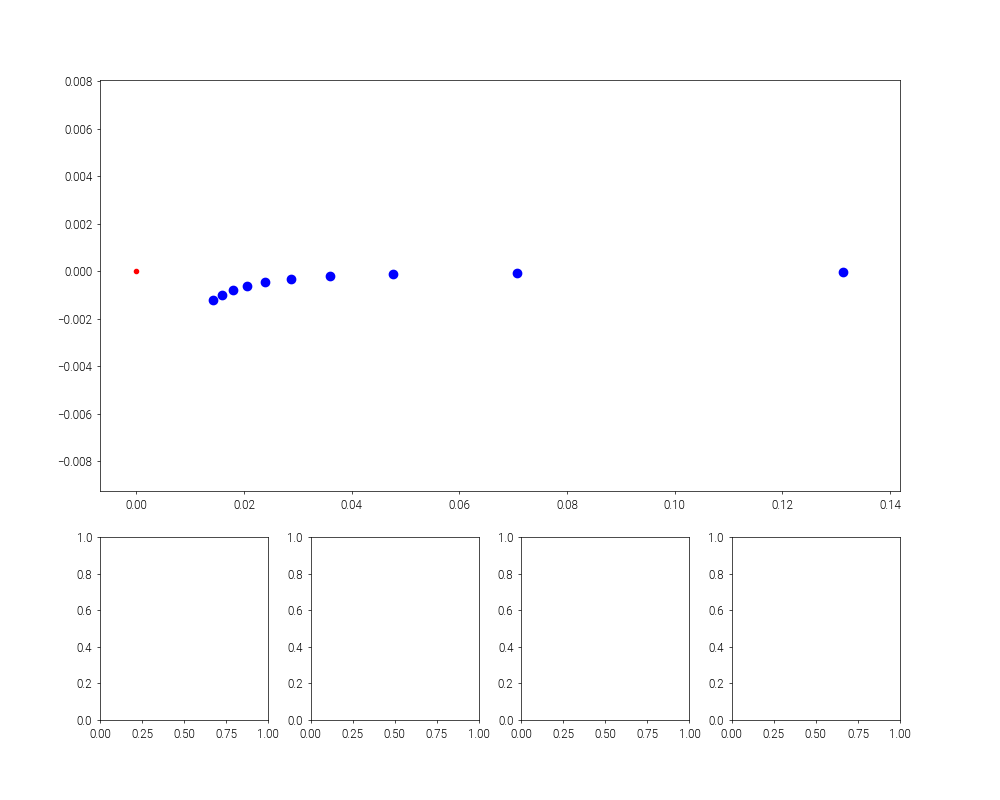

7

In [13]:
# Filter eigenvalues
evals = solver.eigenvalues.copy()
evals = evals[np.isfinite(evals)]
#evals = evals[np.abs(evals.real) < 0.5]
#evals = evals[np.abs(evals.imag) < 0.5]

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot2grid((3,4), (0,0), rowspan=2, colspan=4)
ax1.scatter(evals.real, evals.imag, picker=2)
#ax1.set_xscale('symlog')
#ax1.set_yscale('symlog')
active_dot, = ax1.plot(0, 0, '.r')
active_ev = fig.suptitle('')

ax2 = plt.subplot2grid((3,4), (2,0))
ax3 = plt.subplot2grid((3,4), (2,1))
ax4 = plt.subplot2grid((3,4), (2,2))
ax5 = plt.subplot2grid((3,4), (2,3))

scales = 1
p0.set_scales(scales)
a0.set_scales(scales)
for field in solver.state.fields:
    field.set_scales(scales)
z = domain.grid(0, scales=scales)

def plot_mode(event):
    # Update active eigenvalue
    x, y = event.mouseevent.xdata, event.mouseevent.ydata
    index = np.argmin(np.abs(solver.eigenvalues - (x + 1j*y)))
    ev = solver.eigenvalues[index]
    active_dot.set_xdata([ev.real])
    active_dot.set_ydata([ev.imag])
    active_ev.set_text('%i: %s' %(index, ev))
    # Plot mode
    solver.set_state(index)
    u = solver.state['u']['g']
    w = solver.state['w']['g']
    wz = solver.state['wz']['g']
    p1 = solver.state['p1']['g']
    a1 = solver.state['a1']['g']
    ρ1 = -a1 / a0['g']**2
    phase = p1[0]
    phase = phase / np.abs(phase)
    ax2.cla()
    ax2.plot(z, (u/phase).real, '-b')
    ax2.plot(z, (u/phase).imag, '--b')
    ax2.set_title('u')
    ax3.cla()
    ax3.plot(z, (w/phase).real, '-b')
    ax3.plot(z, (w/phase).imag, '--b')
    ax3.set_title('w')
    ax4.cla()
    ax4.plot(z, (p1/phase).real, '-b')
    ax4.plot(z, (p1/phase).imag, '--b')
    ax4.set_title('p1')
    ax5.cla()
    ax5.plot(z, (ρ1/phase).real, '-b')
    ax5.plot(z, (ρ1/phase).imag, '--b')
    ax5.set_title('ρ1')

fig.canvas.mpl_connect('pick_event', plot_mode)

In [14]:
dau = np.array([ 1.52930137 -7.68759006e-06j,  0.09540199 -1.00573753e-05j,
        0.04099516 -3.71438461e-05j,  0.02599228 -9.21939220e-05j,
        0.01901339 -1.73079912e-04j,  0.01498024 -2.79080697e-04j,
        0.01234558 -4.08958954e-04j,  0.01047713 -5.59984130e-04j,
        0.00906668 -7.27115340e-04j,  0.00794590 -9.02961662e-04j])

In [15]:
2*dau

array([ 3.05860274 -1.53751801e-05j,  0.19080398 -2.01147506e-05j,
        0.08199032 -7.42876922e-05j,  0.05198456 -1.84387844e-04j,
        0.03802678 -3.46159824e-04j,  0.02996048 -5.58161394e-04j,
        0.02469116 -8.17917908e-04j,  0.02095426 -1.11996826e-03j,
        0.01813336 -1.45423068e-03j,  0.01589180 -1.80592332e-03j])

In [16]:
solver.eigenvalues

array([ 0.13131883 -2.14157923e-05j,  0.07066312 -5.32031455e-05j,
        0.04774856 -1.11529096e-04j,  0.03592283 -1.95387220e-04j,
        0.02874588 -3.04433877e-04j,  0.02393491 -4.38248570e-04j,
        0.02048298 -5.95939162e-04j,  0.01787733 -7.75692731e-04j,
        0.01582876 -9.74313239e-04j,  0.01416148 -1.18697833e-03j])

In [17]:
index = 3
ev = solver.eigenvalues[index]
print('ω_tide:', 2 * ev.real)
print('t_tide:', 1 / (2*ev.real))
print('P_tide:', 2*np.pi / (2*ev.real))
print('t_visc:', -1 / ev.imag)


ω_tide: 0.0718456568967
t_tide: 13.9187258241
P_tide: 87.4539335929
t_visc: 5118.04201579


<IPython.core.display.Javascript object>


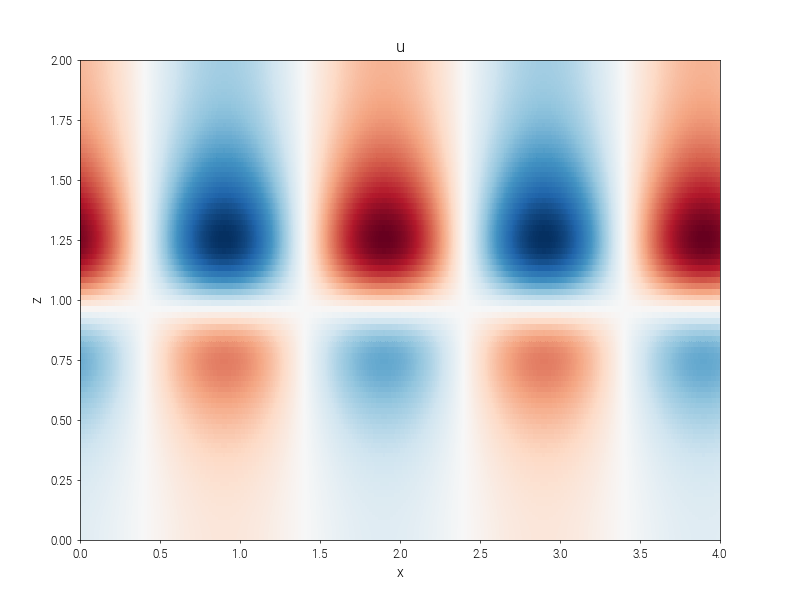

In [18]:
x = np.linspace(0, 4, 1000)[:,None]
z = domain.grid(0, scales=scales)
Z, X = plot_tools.quad_mesh(z.flatten(), x.flatten())

index = 0
solver.set_state(index)
a1 = solver.state['a1']
a0.set_scales(scales)
a1.set_scales(scales)
ρ1 = -a1['g'] / a0['g']**2
R1 = ρ1 * np.exp(1j*kx*x)

u = solver.state['u']
u.set_scales(scales)
U = u['g'] * np.exp(1j*kx*x)
fig, axes = plt.subplots(1, 1)
axes.pcolormesh(X, Z, U.real)
axes.set_xlabel('x')
axes.set_ylabel('z')
axes.set_title('u')

In [21]:
# dt(a1) + w*a0z -   a0*div_u = 0
# dt(p1) + w*p0z + γ*p0*div_u = 0

kx = param.k_tide
dz = problem.namespace['dz']
a0z = problem.namespace['a0z']
p0z = problem.namespace['p0z']
γ = param.γ

σ = solver.eigenvalues[index]
u = solver.state['u']
w = solver.state['w']
a1 = solver.state['a1']
p1 = solver.state['p1']

dx = lambda A: 1j*kx*A
dt = lambda A: -1j*σ*A

xix = u / dt(1)
xiz = w / dt(1)
div_u = (dx(u) + dz(w))

a1g = ((-w*a0z + a0*div_u) / dt(1)).evaluate()
p1g = ((-w*p0z - γ*p0*div_u) / dt(1)).evaluate()

In [22]:
print(np.allclose(a1['c'], a1g['c']))
print(np.allclose(p1['c'], p1g['c']))

True
True


In [23]:
U = []
W = []
n = 3
for i in range(n):
    solver.set_state(i)
    ui = domain.new_field()
    wi = domain.new_field()
    ui['c'] = solver.state['u']['c']
    wi['c'] = solver.state['w']['c']
    U.append(ui)
    W.append(wi)
    
integ = problem.namespace['integ']
ρ0 = 1 / a0

g = np.zeros((n, n), dtype=np.complex128)
for i in range(n):
    for j in range(n):
        g[i,j] = integ(ρ0*(U[i]*np.conj(U[j]) + W[i]*np.conj(W[j]))).evaluate()['c'][0]

In [24]:
g.real

array([[  2.14756120e-04,   7.15522240e-09,  -2.39002979e-10],
       [  7.15522240e-09,   5.00910220e-04,   1.91672643e-08],
       [ -2.39002979e-10,   1.91672643e-08,   3.34743938e-04]])

In [25]:
ev = solver.eigenvalues[index]
γ = ev.imag
ω0 = np.sqrt(ev.real**2 + γ**2)

In [26]:
ω = 0.05
FA2 = (ω0**2 - ω**2)**2 + 4*γ**2*ω**2
A = FA2**(-1/2)
A

0.053187712654743091

In [27]:
ω

0.05

In [28]:
2*np.pi / ω

125.66370614359172

In [29]:
1 / γ

-17382.348773459165

<IPython.core.display.Javascript object>


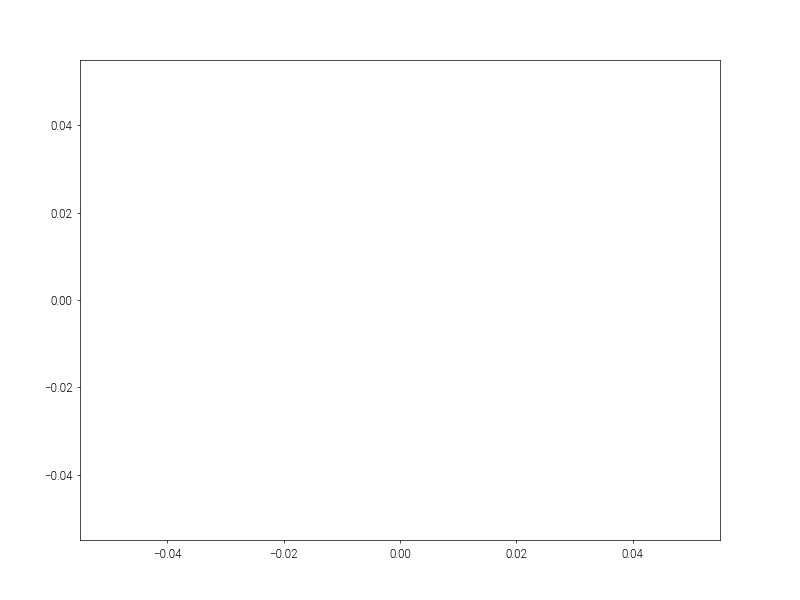

In [30]:
# Filter eigenvalues
evals = solver.eigenvalues.copy()
evals = evals[np.isfinite(evals)]
evals = evals[np.abs(evals.real) < 1]
evals = evals[np.abs(evals.imag) > 1e-2]
evals = evals[np.abs(evals.imag) < 1e2]

fig, axes = plt.subplots(1, 1)
axes.scatter(evals.real, evals.imag)

<IPython.core.display.Javascript object>


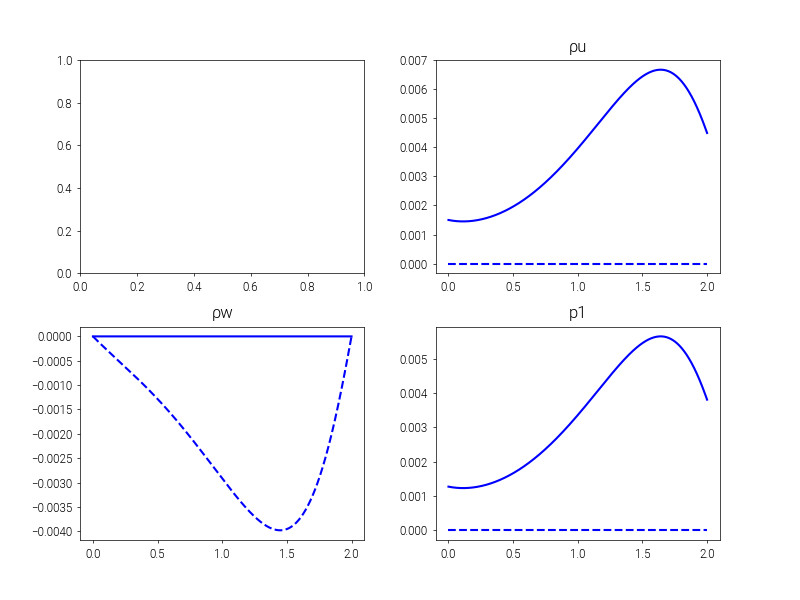

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
scales = 4
a0.set_scales(scales)
for field in solver.state.fields:
    field.set_scales(scales)
z = domain.grid(0, scales=scales)
for ev in evals:
    print(ev)
    index = np.where(solver.eigenvalues == ev)[0][0]
    solver.set_state(index)
    u = solver.state['u']['g']
    w = solver.state['w']['g']
    wz = solver.state['wz']['g']
    p1 = solver.state['p1']['g']
    a1 = solver.state['a1']['g']
    ρ1 = -a1 / a0['g']**2
    ax1.plot(z, np.abs(u))
    ax1.set_title('|u|')
    ax2.plot(z, np.abs(w))
    ax2.set_title('|w|')
    ax3.plot(z, np.abs(p1))
    ax3.set_title('|p1|')
    ax4.plot(z, np.abs(ρ1))
    ax4.set_title('|ρ1|')